In [1]:
import pandas as pd
import datetime as dt
import regex as re
import os
from pathlib import Path
import utils_laramie
import numpy as np

### Read in the data

In [459]:
# def get_all_raw_data(dirpath = Path('raw_data/')):
#     csv_list = [filename for filename in os.listdir(dirpath)]
#     return csv_list
# def clean_col_names(list_dfs, list_csvs):

#     list_cols = [df.columns.to_list() for df in list_dfs]
#     zipped = zip(list_csvs,list_cols)
#     name_list = []
#     column_list = []
#     for tup in list(zipped):
#         name = tup[0]
#         match = re.match(r'(\w+)_',name)
#         name = match.group(1)
#         for col in tup[1]:
#             if name.lower() != col.lower():
#                 name_list.append((name.upper()+'_'+col.lower()))
#             else:
#                 name_list.append(name.upper())

#     return name_list

# def drop_unnamed(df):
#     for col in df.columns:
#         if 'Unnamed' in str(col):
#             df.drop(columns= col, inplace=True)
#     return df
    
# def get_df(list_of_csvs= ['SPY_data.csv','TR_data.csv','VIX_data.csv']):
#     """concat a list of csvs into a single df"""
#     # make a list of dataframes
#     list_dfs = [pd.read_csv(f'raw_data/{_csv}', parse_dates = True, infer_datetime_format = True) for _csv in list_of_csvs]
#     for df in list_dfs:
#         df.drop_duplicates(inplace=True)
#         df['date'] = pd.to_datetime(df['date']).dt.date
#         df['date'] = pd.to_datetime(df['date'])
#         df = drop_unnamed(df)
#     clean_headers = clean_col_names(list_dfs,list_of_csvs)
#     merged_df = pd.concat(list_dfs, axis=1, join= 'inner')
#     merged_df.columns = clean_headers
#     return merged_df
# x = get_df()
# x 

In [460]:
# def get_df(list_of_csvs= ['SPY_data.csv','TR_data.csv','VIX_data.csv']):
#     """concat a list of csvs into a single df"""
#     list_dfs = [pd.read_csv(f'raw_data/{_csv}', parse_dates = True, infer_datetime_format = True) for _csv in list_of_csvs]
#     for df in list_dfs:
#         df.drop_duplicates(inplace=True)
#         df['date'] = pd.to_datetime(df['date']).dt.date
#         df['date'] = pd.to_datetime(df['date'])
#         df = drop_unnamed(df)
#         df.set_index('date',inplace=True)
#     clean_headers = clean_col_names(list_dfs,list_of_csvs)
#     merged_df = pd.concat(list_dfs, axis=1, join= 'inner')  
#     merged_df.columns = clean_headers
#     return merged_df
# x = get_df()
# x 

In [4]:
# imports for creating dataframe
from utils_laramie import get_df, get_all_raw_data, drop_unnamed

# imports for getting weekly range
from utils_laramie import calc_weekly_range

#imports for grouping data into weekly windows
from utils_laramie import grp_y_wk_d, drop_off_weeks

#shape data
from utils_laramie import get_X_y




### Create Weekly Range

In [462]:
# def get_day_names(df):    
#     df = get_df(get_all_raw_data())
#     df.reset_index(inplace=True)
#     df['DayOfWeek'] = df['date'].dt.day_name()
#     df.set_index('date', inplace=True)
#     return df

# def calc_weekly_range(df):
#     """ Must run "get_day_names" first"""
#     week_high = 0  
#     week_low = 9999999
#     for index, row in df.iterrows():
#         if df.loc[index, 'DayOfWeek'] == 'Monday':
#             week_high = df.loc[index,'SPY_high']
#             week_low = df.loc[index,'SPY_low']
#         else: 
#             if df.loc[index,'SPY_high'] > week_high:
#                 week_high=df.loc[index,'SPY_high']
#             if df.loc[index,'SPY_low'] < week_low:
#                 week_low=df.loc[index,'SPY_low']
#             if df.loc[index,'DayOfWeek'] == 'Friday':
#                 df.loc[index,'weekly_range'] = week_high - week_low
#     return df.fillna(0)

In [10]:
# Step 1) get data
df = (get_df(get_all_raw_data()))

# Step 2)

"""ADD INDICATORS -- if you change column names for SPY columns, change them BACK to:
 [ SPY_open	,SPY_high, SPY_low,	SPY_close ] before next step"""

# Step 3) get weekly range
df = calc_weekly_range(df)

# Step 4) group by year, week, and day **SAVE AS A DIFFERENT DATAFRAME***
grouped_df = grp_y_wk_d(df)

# Step 5) Add these two dataframes for Reindexing method
       
df_1 = df.reset_index() ### df_1 = our data, with indicators and weekly range
        
df_2 = drop_off_weeks(grouped_df) ### df_2 is in the right format for LSTM, but has no index


In [7]:

# Step 6) Run this function
def reindex_df(df_2, df_1):
    df_copy = pd.merge(df_2, df_1, on= df_2.columns.to_list() )
    df_copy.set_index('date', inplace=True)
    return df_copy 

In [8]:
clean_df = reindex_df(df_2, df_1)
clean_df.head()

,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,SPY_trade_count,SPY_vwap,TR,VIX_open,VIX_high,VIX_low,VIX_close,weekly_range
date,,,,,,,,,,,,,
2015-12-07,209.20,209.7295,207.20,208.27,102027111.0,374705.0,208.276128,2.5295,15.65,17.18,15.58,15.84,0.0000
2015-12-08,206.48,208.2890,205.78,206.99,103372367.0,387782.0,206.966276,2.5090,17.69,18.33,16.52,17.60,0.0000
2015-12-09,206.20,208.6800,204.18,205.33,162401537.0,586210.0,206.034646,4.5000,18.05,20.13,15.72,19.61,0.0000
2015-12-10,205.44,207.4300,205.14,205.86,116128858.0,404992.0,206.102975,2.2900,19.25,19.72,18.13,19.34,0.0000
2015-12-11,203.38,204.1400,201.51,201.88,211173305.0,669924.0,203.150102,4.3500,21.36,25.27,20.88,24.39,8.2195


In [ ]:
grouped_df = grp_y_wk_d(df)
df_1 = df.reset_index()
df_2 = drop_off_weeks(grouped_df)

In [41]:

display(df_2.head())
display(df_1.head())

,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,SPY_trade_count,SPY_vwap,TR,VIX_open,VIX_high,VIX_low,VIX_close,weekly_range
0,209.20,209.7295,207.20,208.27,102027111.0,374705.0,208.276128,2.5295,15.65,17.18,15.58,15.84,0.0000
1,206.48,208.2890,205.78,206.99,103372367.0,387782.0,206.966276,2.5090,17.69,18.33,16.52,17.60,0.0000
2,206.20,208.6800,204.18,205.33,162401537.0,586210.0,206.034646,4.5000,18.05,20.13,15.72,19.61,0.0000
3,205.44,207.4300,205.14,205.86,116128858.0,404992.0,206.102975,2.2900,19.25,19.72,18.13,19.34,0.0000
4,203.38,204.1400,201.51,201.88,211173305.0,669924.0,203.150102,4.3500,21.36,25.27,20.88,24.39,8.2195


,date,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,SPY_trade_count,SPY_vwap,TR,VIX_open,VIX_high,VIX_low,VIX_close,weekly_range
0,2015-12-02,210.60,211.0000,208.2300,208.54,108069059,367013,209.563055,2.7700,15.04,16.49,14.71,15.91,0.0000
1,2015-12-03,208.90,209.1500,204.7511,205.58,166224154,546768,206.878936,4.3989,15.87,19.35,15.86,18.11,0.0000
2,2015-12-04,206.10,209.9700,205.9300,209.66,192878747,556731,208.178631,4.3900,17.43,17.65,14.69,14.81,6.2489
3,2015-12-07,209.20,209.7295,207.2000,208.27,102027111,374705,208.276128,2.5295,15.65,17.18,15.58,15.84,0.0000
4,2015-12-08,206.48,208.2890,205.7800,206.99,103372367,387782,206.966276,2.5090,17.69,18.33,16.52,17.60,0.0000


In [ ]:
def reindex_df(df_2, df_1):
    df_copy = pd.merge(df_2, df_1, on= df_2.columns.to_list() )
    df_copy.set_index('date', inplace=True)
    return df_copy 

In [42]:
df_merged = pd.merge(df_2, df_1, on= df_2.columns.to_list() )

In [44]:
df_merged.set_index('date', inplace=True)

In [45]:
df_merged

,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,SPY_trade_count,SPY_vwap,TR,VIX_open,VIX_high,VIX_low,VIX_close,weekly_range
date,,,,,,,,,,,,,
2015-12-07,209.20,209.7295,207.20,208.27,102027111.0,374705.0,208.276128,2.5295,15.65,17.18,15.58,15.84,0.0000
2015-12-08,206.48,208.2890,205.78,206.99,103372367.0,387782.0,206.966276,2.5090,17.69,18.33,16.52,17.60,0.0000
2015-12-09,206.20,208.6800,204.18,205.33,162401537.0,586210.0,206.034646,4.5000,18.05,20.13,15.72,19.61,0.0000
2015-12-10,205.44,207.4300,205.14,205.86,116128858.0,404992.0,206.102975,2.2900,19.25,19.72,18.13,19.34,0.0000
2015-12-11,203.38,204.1400,201.51,201.88,211173305.0,669924.0,203.150102,4.3500,21.36,25.27,20.88,24.39,8.2195
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-14,420.98,424.5500,415.79,417.00,91251505.0,858504.0,419.220077,8.7600,31.03,33.18,30.06,31.77,0.0000
2022-03-15,419.66,426.8400,418.42,426.17,104219651.0,920659.0,422.752423,9.8400,33.13,33.83,29.57,29.83,0.0000
2022-03-16,429.94,435.6800,424.80,435.55,138130298.0,1344164.0,431.339744,10.8800,29.02,29.80,26.29,26.67,0.0000


In [ ]:
grouped_df['test'] = ''+grouped_df['year'].astype(str)+' '+grouped_df['week'].astype(str)+' '+grouped_df['day'].astype(str)

In [ ]:
ind_list = grouped_df['test'].to_list()

examp = ind_list[0]
examp



'2015 50 1'

In [28]:
import datetime
from dateutil.relativedelta import relativedelta
 
week = 50
year = 2015
date = datetime.date(year, 1, 1) + relativedelta(weeks=+week)
print(date)
print(date.weekday())

2015-12-17
3


In [ ]:
from datetime import datetime

dt_object1 = datetime.strptime( examp, "%Y %U %w")

In [ ]:
dt_object1

datetime.datetime(2015, 12, 14, 0, 0)

In [ ]:
grouped_df.tail()

,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,SPY_trade_count,SPY_vwap,TR,VIX_open,VIX_high,VIX_low,VIX_close,weekly_range
1050,420.98,424.55,415.79,417.00,91251505.0,858504.0,419.220077,8.76,31.03,33.18,30.06,31.77,0.00
1051,419.66,426.84,418.42,426.17,104219651.0,920659.0,422.752423,9.84,33.13,33.83,29.57,29.83,0.00
1052,429.94,435.68,424.80,435.55,138130298.0,1344164.0,431.339744,10.88,29.02,29.80,26.29,26.67,0.00
1053,433.70,441.07,433.19,441.07,100157174.0,784018.0,437.706981,7.88,26.51,27.47,25.25,25.67,0.00
1054,437.81,444.86,437.22,444.31,102327793.0,790235.0,441.458916,7.64,26.36,26.82,23.85,23.87,29.07


In [ ]:
def window_data(df, window, chunk_rows, feature_col_1, feature_col_2, target_col):
    X_list = df.iloc[:,feature_col_1:feature_col_2].values.tolist()
    X_chunks=[X_list[i:i + chunk_rows] for i in range(0, len(X_list), chunk_rows)]
    X = [X_chunks[i:i+window] for i in range (len(X_chunks)-window)]
    y_list=df.iloc[:,target_col].values.tolist()
    y_chunks = [y_list[i + chunk_rows-1] for i in range(0, len(y_list), chunk_rows)]
    y = [y_chunks[i+window] for i in range(len(y_chunks)-window)]
    return np.array(X), np.array(y)

In [ ]:
len(grouped_df.columns.to_list()[:-1])


11

In [ ]:
def get_feature_col_2(df):
    return (len(grouped_df.columns.to_list()[:-1]))

def get_target_col(df):
    return len(grouped_df.columns.to_list())-1

In [ ]:
X , y = window_data(grouped_df, 3, 5, 0, get_feature_col_2(grouped_df), get_target_col(grouped_df))

In [ ]:
def data_splited_scaled(X,y,df):
    '''
    This function splits X and y into training and testing sets, scales the data with MinMaxScaler and reshapes features data for the LSTM model .
    '''
    # Use 70% of the data for training and the remainder for testing
    split = int(0.7 * len(X))
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the MinMaxScaler object with the training feature data X_train
    X_scaler = scaler.fit(X_train.ravel().reshape(-1,1))

    # Scale the features training and testing sets
    X_train_scaled= X_scaler.transform(X_train.ravel().reshape(-1,1))
    X_test_scaled = X_scaler.transform(X_test.ravel().reshape(-1,1))

    # Fit the MinMaxScaler object with the training target data y_train
    y_scaler = scaler.fit(y_train.ravel().reshape(-1,1))

    # Scale the target training and testing sets
    y_train_scaled = y_scaler.transform(y_train.ravel().reshape(-1,1))
    y_test_scaled = y_scaler.transform(y_test.ravel().reshape(-1,1))

    # Reshape the features for the model
    feature_num = get_feature_col_2(df)
    X_train_scaled = X_train_scaled.reshape((X_train.shape[0], X_train.shape[1],X_train.shape[2], feature_num))
    X_test_scaled = X_test_scaled.reshape((X_test.shape[0], X_test.shape[1],X_train.shape[2], feature_num))

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler

In [ ]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler = data_splited_scaled(X,y,grouped_df)

In [ ]:
df['tr_weekly'] = df['TR'].rolling(window=5).sum().mean()

In [ ]:
df['tr_5'] = df['TR'].rolling(window=5).mean()
df['tr_project'] = np.log(df['tr_5'] + df['tr_weekly'])

In [ ]:

df = calc_weekly_range(df)
df = grp_y_wk_d(df)
df = drop_off_weeks(df)
df.head()

,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,SPY_trade_count,SPY_vwap,TR,VIX_open,VIX_high,VIX_low,VIX_close,tr_weekly,tr_5,tr_project,weekly_range
0,209.20,209.7295,207.20,208.27,102027111.0,374705.0,208.276128,2.5295,15.65,17.18,15.58,15.84,18.757144,0.00000,0.000000,0.0000
1,206.48,208.2890,205.78,206.99,103372367.0,387782.0,206.966276,2.5090,17.69,18.33,16.52,17.60,18.757144,3.31948,3.094519,0.0000
2,206.20,208.6800,204.18,205.33,162401537.0,586210.0,206.034646,4.5000,18.05,20.13,15.72,19.61,18.757144,3.66548,3.110070,0.0000
3,205.44,207.4300,205.14,205.86,116128858.0,404992.0,206.102975,2.2900,19.25,19.72,18.13,19.34,18.757144,3.24370,3.091081,0.0000
4,203.38,204.1400,201.51,201.88,211173305.0,669924.0,203.150102,4.3500,21.36,25.27,20.88,24.39,18.757144,3.23570,3.090717,8.2195


In [ ]:
raw_cols = df.columns.to_list()

In [ ]:
raw_cols = raw_cols[:-4]

In [ ]:
raw_cols

['SPY_open',
 'SPY_high',
 'SPY_low',
 'SPY_close',
 'SPY_volume',
 'SPY_trade_count',
 'SPY_vwap',
 'TR',
 'VIX_open',
 'VIX_high',
 'VIX_low',
 'VIX_close']

In [ ]:
df['day_range'] = df['TR']
df.insert(0, 'day_range', df.pop('day_range'))

df['pct_change'] = (df['SPY_close']-df['SPY_open'])/df['SPY_open']
df.insert(1, 'pct_change', df.pop('pct_change'))

df['day_range_VIX'] = df['VIX_high']-df['VIX_low']
df.insert(2, 'day_range', df.pop('day_range'))

df['pct_changeVIX'] = (df['VIX_close']-df['VIX_open'])/df['SPY_open']
df.insert(3, 'pct_changeVIX', df.pop('pct_changeVIX'))

df['mean_volume'] = df['SPY_volume']/df['SPY_trade_count']
df.insert(4, 'mean_volume', df.pop('mean_volume'))


In [ ]:
df.head()

,pct_change,SPY_open,day_range,pct_changeVIX,mean_volume,SPY_high,SPY_low,SPY_close,SPY_volume,SPY_trade_count,...,TR,VIX_open,VIX_high,VIX_low,VIX_close,tr_weekly,tr_5,tr_project,weekly_range,day_range_VIX
0,-0.004446,209.20,2.5295,0.000908,272.286495,209.7295,207.20,208.27,102027111.0,374705.0,...,2.5295,15.65,17.18,15.58,15.84,18.757144,0.00000,0.000000,0.0000,1.60
1,0.002470,206.48,2.5090,-0.000436,266.573402,208.2890,205.78,206.99,103372367.0,387782.0,...,2.5090,17.69,18.33,16.52,17.60,18.757144,3.31948,3.094519,0.0000,1.81
2,-0.004219,206.20,4.5000,0.007565,277.036449,208.6800,204.18,205.33,162401537.0,586210.0,...,4.5000,18.05,20.13,15.72,19.61,18.757144,3.66548,3.110070,0.0000,4.41
3,0.002044,205.44,2.2900,0.000438,286.743585,207.4300,205.14,205.86,116128858.0,404992.0,...,2.2900,19.25,19.72,18.13,19.34,18.757144,3.24370,3.091081,0.0000,1.59
4,-0.007375,203.38,4.3500,0.014898,315.219794,204.1400,201.51,201.88,211173305.0,669924.0,...,4.3500,21.36,25.27,20.88,24.39,18.757144,3.23570,3.090717,8.2195,4.39


In [ ]:
df_clean = df.drop(columns=raw_cols[:-1])
df_clean = df[[c for c in df_clean if c not in ['weekly_range'] ] + ['weekly_range']]

In [ ]:
df_clean

,pct_change,day_range,pct_changeVIX,mean_volume,VIX_close,tr_weekly,tr_5,tr_project,day_range_VIX,weekly_range
0,-0.004446,2.5295,0.000908,272.286495,15.84,18.757144,0.00000,0.000000,1.60,0.0000
1,0.002470,2.5090,-0.000436,266.573402,17.60,18.757144,3.31948,3.094519,1.81,0.0000
2,-0.004219,4.5000,0.007565,277.036449,19.61,18.757144,3.66548,3.110070,4.41,0.0000
3,0.002044,2.2900,0.000438,286.743585,19.34,18.757144,3.24370,3.091081,1.59,0.0000
4,-0.007375,4.3500,0.014898,315.219794,24.39,18.757144,3.23570,3.090717,4.39,8.2195
...,...,...,...,...,...,...,...,...,...,...
1050,-0.009454,8.7600,0.001758,106.291299,31.77,18.757144,10.04800,3.360554,3.12,0.0000
1051,0.015513,9.8400,-0.007864,113.201143,29.83,18.757144,9.59800,3.344808,4.26,0.0000
1052,0.013048,10.8800,-0.005466,102.762980,26.67,18.757144,9.12200,3.327879,3.51,0.0000
1053,0.016993,7.8800,-0.001937,127.748564,25.67,18.757144,9.32000,3.334956,2.22,0.0000


<AxesSubplot:>

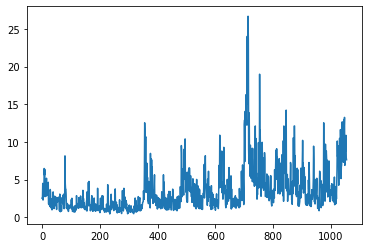

In [ ]:
df_clean['day_range'].plot()

In [ ]:
df_clean.to_csv('clean_data/basic_spy_vix.csv')

In [ ]:
X , y = get_X_y(df_clean)

c:\Users\Laramie\Desktop\Project_Two\Project2\utils_laramie.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target']= df['weekly_range'].shift(-5)
c:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
c:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
len(X)

210

In [ ]:
len(y)

210

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D

In [ ]:
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)
        
    # def inverse_transform(self, X):
    #     x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
    #     return np.reshape(super().inverse_transform(x), newshape=X.shape)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
scaler = MinMaxScaler3D()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


In [ ]:
display(X_train_scaled.shape)
display(y_train.shape)

(157, 5, 5)

(157, 1, 1)

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train_scaled.shape[0], X_train_scaled.shape[1], X_train_scaled.shape[2]) ))

model.add(Dense(1, activation='relu'))


In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 157, 5, 100)       600       
                                                                 
 dense_32 (Dense)            (None, 157, 5, 1)         101       
                                                                 
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.output_shape

(None, 157, 5, 1)

In [ ]:
# from tensorflow.keras.layers import Input
# from tensorflow.keras.models import Model
# visible = Input(shape=X_train_scaled.shape[1:])
# hidden = Dense(X_train_scaled.shape[-1])(visible)
# model = Model(inputs=visible, outputs=hidden)


In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

In [ ]:
model_shallow = model.fit(X_train_scaled, y_train, validation_split=0.3, epochs=400)

Epoch 1/400
4/4 [==============================] - 0s 46ms/step - loss: 84.9720 - mse: 84.9720 - val_loss: 181.6854 - val_mse: 181.6854
Epoch 2/400
4/4 [==============================] - 0s 7ms/step - loss: 83.9051 - mse: 83.9051 - val_loss: 180.2310 - val_mse: 180.2310
Epoch 3/400
4/4 [==============================] - 0s 7ms/step - loss: 82.8102 - mse: 82.8102 - val_loss: 178.7435 - val_mse: 178.7435
Epoch 4/400
4/4 [==============================] - 0s 8ms/step - loss: 81.6526 - mse: 81.6526 - val_loss: 177.2112 - val_mse: 177.2112
Epoch 5/400
4/4 [==============================] - 0s 7ms/step - loss: 80.4987 - mse: 80.4987 - val_loss: 175.6159 - val_mse: 175.6159
Epoch 6/400
4/4 [==============================] - 0s 8ms/step - loss: 79.3054 - mse: 79.3053 - val_loss: 173.9585 - val_mse: 173.9585
Epoch 7/400
4/4 [==============================] - 0s 7ms/step - loss: 78.0699 - mse: 78.0699 - val_loss: 172.2495 - val_mse: 172.2495
Epoch 8/400
4/4 [==============================] - 0s 

In [ ]:
model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)

2/2 - 0s - loss: 17.7818 - mse: 17.7818 - 16ms/epoch - 8ms/step


In [ ]:
predicted = model.predict(X_test_scaled)

In [ ]:
y_test.shape

(53, 1, 1)

In [ ]:
predicted.shape

(53, 5, 1)

In [ ]:
predicted

array([[[ 3.1281948 ],
        [ 4.713644  ],
        [ 2.280076  ],
        [ 4.8648324 ],
        [ 2.3571923 ]],

       [[17.466572  ],
        [14.844843  ],
        [10.340664  ],
        [ 9.525674  ],
        [11.532473  ]],

       [[ 5.251856  ],
        [ 5.5686855 ],
        [ 3.8859243 ],
        [ 3.9016008 ],
        [ 3.464153  ]],

       [[11.896702  ],
        [14.119352  ],
        [17.404385  ],
        [14.873345  ],
        [14.459837  ]],

       [[ 3.639175  ],
        [ 3.0209167 ],
        [ 5.7121596 ],
        [ 6.6544204 ],
        [ 3.3104377 ]],

       [[ 6.1933684 ],
        [ 5.8792744 ],
        [ 4.5399995 ],
        [ 5.326059  ],
        [ 7.86174   ]],

       [[ 6.121342  ],
        [ 5.1142592 ],
        [ 4.8685575 ],
        [ 4.8056674 ],
        [ 1.2643942 ]],

       [[16.658112  ],
        [10.005546  ],
        [18.851788  ],
        [16.159151  ],
        [13.854099  ]],

       [[16.789494  ],
        [15.224051  ],
        [12.027582

In [ ]:
len(y)

210

In [ ]:
y_scaler = MinMaxScaler()
y_scaler.fit(y_train.reshape(-1,1))


MinMaxScaler()

In [ ]:
predicted = y_scaler.inverse_transform(predicted.reshape(-1,1))

In [ ]:
len(predicted)

265

In [ ]:
y_test.flatten()

array([ 5.24  ,  5.81  ,  2.75  , 16.6027,  3.23  ,  5.4001,  3.67  ,
       24.95  , 18.31  , 13.87  , 18.5   ,  5.43  ,  3.2363,  1.92  ,
        3.24  ,  6.99  , 14.23  ,  2.17  ,  2.38  ,  2.495 ,  1.27  ,
        7.01  ,  8.0752,  4.42  ,  3.48  , 18.9   ,  5.265 , 13.82  ,
        3.61  ,  6.27  ,  3.83  ,  7.47  ,  6.15  ,  2.47  ,  4.0625,
        9.87  ,  4.5   ,  3.65  ,  5.49  , 11.04  ,  2.79  , 29.07  ,
        9.45  , 15.08  ,  6.99  ,  3.43  ,  3.34  ,  8.21  ,  5.43  ,
       12.45  , 11.76  ,  4.63  , 11.9   ])

In [18]:
combo_df = pd.read_csv('clean_data/combined.csv')
drop_unnamed(combo_df)

In [19]:
combo_df.columns

Index(['pct_change', 'day_range', 'pct_changeVIX', 'mean_volume', 'VIX_close',
       'tr_weekly', 'tr_5', 'tr_project', 'day_range_VIX', 'SPY_open',
       'SPY_high', 'SPY_low', 'SPY_close', 'ATR', 'VBM', 'MI', 'KAMA',
       'BBANDS Upper', 'Moving Average', 'BBands Lower', 'APZ Upper',
       'APZ Lower', 'KC Upper', 'KC Lower', 'DYMI', 'weekly_range'],
      dtype='object')

In [23]:
df_1.head()

,date,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,SPY_trade_count,SPY_vwap,TR,VIX_open,VIX_high,VIX_low,VIX_close,weekly_range
0,2015-12-02,210.60,211.0000,208.2300,208.54,108069059,367013,209.563055,2.7700,15.04,16.49,14.71,15.91,0.0000
1,2015-12-03,208.90,209.1500,204.7511,205.58,166224154,546768,206.878936,4.3989,15.87,19.35,15.86,18.11,0.0000
2,2015-12-04,206.10,209.9700,205.9300,209.66,192878747,556731,208.178631,4.3900,17.43,17.65,14.69,14.81,6.2489
3,2015-12-07,209.20,209.7295,207.2000,208.27,102027111,374705,208.276128,2.5295,15.65,17.18,15.58,15.84,0.0000
4,2015-12-08,206.48,208.2890,205.7800,206.99,103372367,387782,206.966276,2.5090,17.69,18.33,16.52,17.60,0.0000


In [13]:
list_1_as_set = set(combo_df.columns.to_list())
list_2 = (df_1.columns.to_list())

In [14]:
intersection_as_list = list(list_1_as_set.intersection(list_2))

In [15]:
intersection_as_list

['SPY_open', 'VIX_close', 'SPY_close', 'weekly_range', 'SPY_low', 'SPY_high']

In [20]:
df_test = pd.merge(combo_df, df_1, on = intersection_as_list)

In [22]:
df_test.columns

Index(['pct_change', 'day_range', 'pct_changeVIX', 'mean_volume', 'VIX_close',
       'tr_weekly', 'tr_5', 'tr_project', 'day_range_VIX', 'SPY_open',
       'SPY_high', 'SPY_low', 'SPY_close', 'ATR', 'VBM', 'MI', 'KAMA',
       'BBANDS Upper', 'Moving Average', 'BBands Lower', 'APZ Upper',
       'APZ Lower', 'KC Upper', 'KC Lower', 'DYMI', 'weekly_range', 'date',
       'SPY_volume', 'SPY_trade_count', 'SPY_vwap', 'TR', 'VIX_open',
       'VIX_high', 'VIX_low'],
      dtype='object')

In [24]:
def reindex_df(df_2, df_1):
    list_1_as_set = set(df_2.columns.to_list())
    list_2 = (df_1.columns.to_list())
    intersection_as_list = list(list_1_as_set.intersection(list_2))
    df_copy = pd.merge(df_2, df_1, on= intersection_as_list )
    df_copy.set_index('date', inplace=True)
    return df_copy 

In [25]:
df_test = reindex_df(combo_df, df_1)

In [27]:
df_test.to_csv('clean_data/combined_dates.csv')